# EDA Skincare Products

https://www.kaggle.com/datasets/eward96/skincare-products-clean-dataset/data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

In [2]:
path = "D:/Documents-D/datasets/dermis"
df = pd.read_csv(f"{path}/skincare_products_clean.csv")
print(len(df))
df.head()

1138


,product_name,product_url,product_type,clean_ingreds,price
0,The Ordinary Natural Moisturising Factors + HA...,https://www.lookfantastic.com/the-ordinary-nat...,Moisturiser,"['capric triglyceride', 'cetyl alcohol', 'prop...",£5.20
1,CeraVe Facial Moisturising Lotion SPF 25 52ml,https://www.lookfantastic.com/cerave-facial-mo...,Moisturiser,"['homosalate', 'glycerin', 'octocrylene', 'eth...",£13.00
2,The Ordinary Hyaluronic Acid 2% + B5 Hydration...,https://www.lookfantastic.com/the-ordinary-hya...,Moisturiser,"['sodium hyaluronate', 'sodium hyaluronate', '...",£6.20
3,AMELIORATE Transforming Body Lotion 200ml,https://www.lookfantastic.com/ameliorate-trans...,Moisturiser,"['ammonium lactate', 'c12-15', 'glycerin', 'pr...",£22.50
4,CeraVe Moisturising Cream 454g,https://www.lookfantastic.com/cerave-moisturis...,Moisturiser,"['glycerin', 'cetearyl alcohol', 'capric trigl...",£16.00


In [3]:
# convertir string a lista
df.clean_ingreds = df.clean_ingreds.str.strip("[]").str.split(",")
df.clean_ingreds = df.clean_ingreds.apply(lambda x: [i.strip().strip("'") for i in x])
df.head()

,product_name,product_url,product_type,clean_ingreds,price
0,The Ordinary Natural Moisturising Factors + HA...,https://www.lookfantastic.com/the-ordinary-nat...,Moisturiser,"[capric triglyceride, cetyl alcohol, propanedi...",£5.20
1,CeraVe Facial Moisturising Lotion SPF 25 52ml,https://www.lookfantastic.com/cerave-facial-mo...,Moisturiser,"[homosalate, glycerin, octocrylene, ethylhexyl...",£13.00
2,The Ordinary Hyaluronic Acid 2% + B5 Hydration...,https://www.lookfantastic.com/the-ordinary-hya...,Moisturiser,"[sodium hyaluronate, sodium hyaluronate, panth...",£6.20
3,AMELIORATE Transforming Body Lotion 200ml,https://www.lookfantastic.com/ameliorate-trans...,Moisturiser,"[ammonium lactate, c12-15, glycerin, prunus am...",£22.50
4,CeraVe Moisturising Cream 454g,https://www.lookfantastic.com/cerave-moisturis...,Moisturiser,"[glycerin, cetearyl alcohol, capric triglyceri...",£16.00


In [4]:
df.product_type.unique()

array(['Moisturiser', 'Serum', 'Oil', 'Mist', 'Balm', 'Mask', 'Peel',
       'Eye Care', 'Cleanser', 'Toner', 'Exfoliator', 'Bath Salts',
       'Body Wash', 'Bath Oil'], dtype=object)

In [5]:
# Hay muchos tipos de productos diferentes, por lo que es mejor agruparlos en categorías generales
# Además así es más consistente con las clases del otro dataset.
general_types = {
    'Moisturiser': 'Moisturizer',
    'Oil': 'Moisturizer',
    'Balm': 'Moisturizer',
    'Mist': 'Moisturizer',
    'Cleanser': 'Cleanser',
    'Exfoliator': 'Cleanser',
    'Peel': 'Cleanser',
    'Toner': 'Cleanser',
    'Bath Salts': 'Body',
    'Bath Oil': 'Body',
    'Body Wash': 'Body',
    'Serum': 'Treatment',
    'Eye Care': 'Treatment',
    'Mask': 'Face Mask',

}
df['product_type_general'] = df['product_type'].map(general_types)
df.product_type_general.unique()

array(['Moisturizer', 'Treatment', 'Face Mask', 'Cleanser', 'Body'],
      dtype=object)

In [6]:
df = df[df.product_type_general != 'Body']

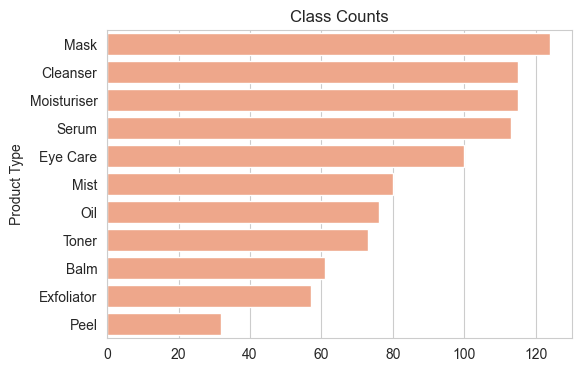

In [7]:
# cantidad de productos según clase (moisturiser, exfoliator, etc.)
class_counts = df.product_type.value_counts()
plt.figure(figsize=(6, 4))
sns.set_style("whitegrid")
sns.barplot(y=class_counts.index, x=class_counts.values, color="lightsalmon")
plt.title("Class Counts")
plt.ylabel("Product Type")
plt.show()

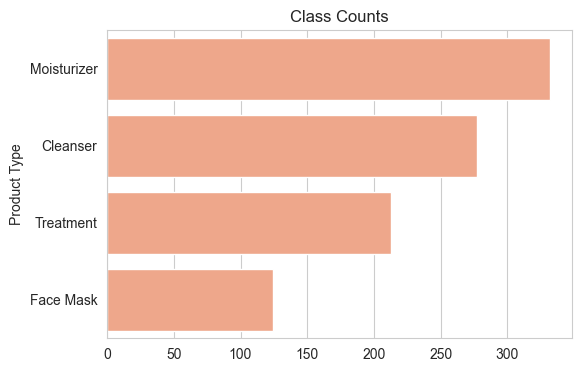

In [8]:
# cantidad de productos según clase general (moisturiser, exfoliator, etc.)
class_counts_general = df.product_type_general.value_counts()
plt.figure(figsize=(6, 4))
sns.set_style("whitegrid")
sns.barplot(y=class_counts_general.index, x=class_counts_general.values, color="lightsalmon")
plt.title("Class Counts")
plt.ylabel("Product Type")
plt.show()

<Figure size 1000x600 with 0 Axes>

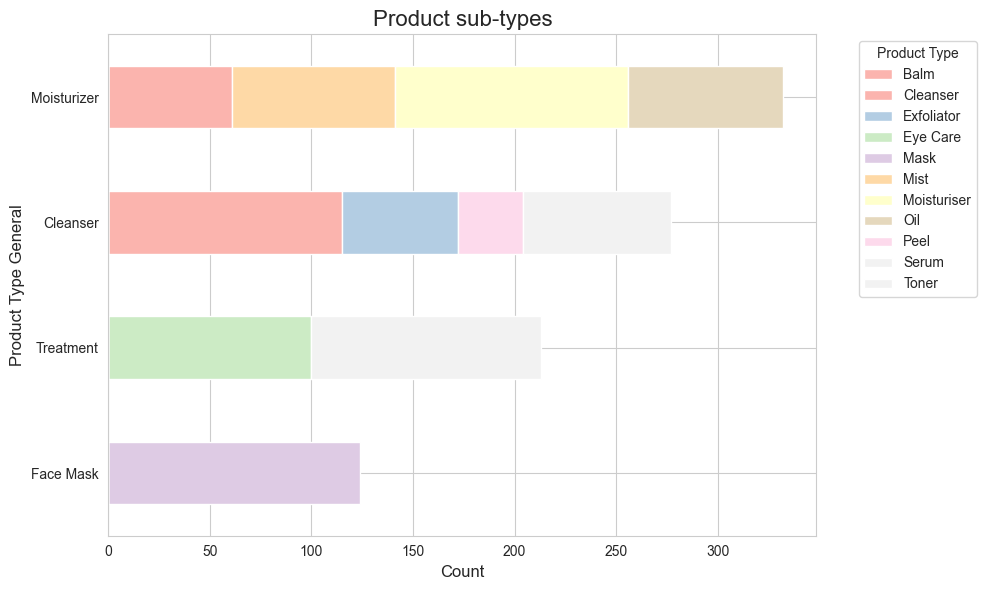

In [9]:
# este es el mismo que el anterior, pero resaltando los sub-tipos
grouped_data = df.groupby(['product_type_general', 'product_type']).size().unstack(fill_value=0)
grouped_data = grouped_data.loc[class_counts_general.sort_values(ascending=True).index]

plt.figure(figsize=(10, 6))
grouped_data.plot(kind='barh', stacked=True, colormap='Pastel1', figsize=(10, 6))

plt.title("Product sub-types", fontsize=16)
plt.xlabel("Count", fontsize=12)
plt.ylabel("Product Type General", fontsize=12)
plt.legend(title="Product Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

In [10]:
# todos los ingredientes
unique_ingredients = set()
for ingredients_list in df['clean_ingreds']:
    unique_ingredients.update(ingredients_list)

num_unique_ingredients = len(unique_ingredients)
num_unique_ingredients

2466

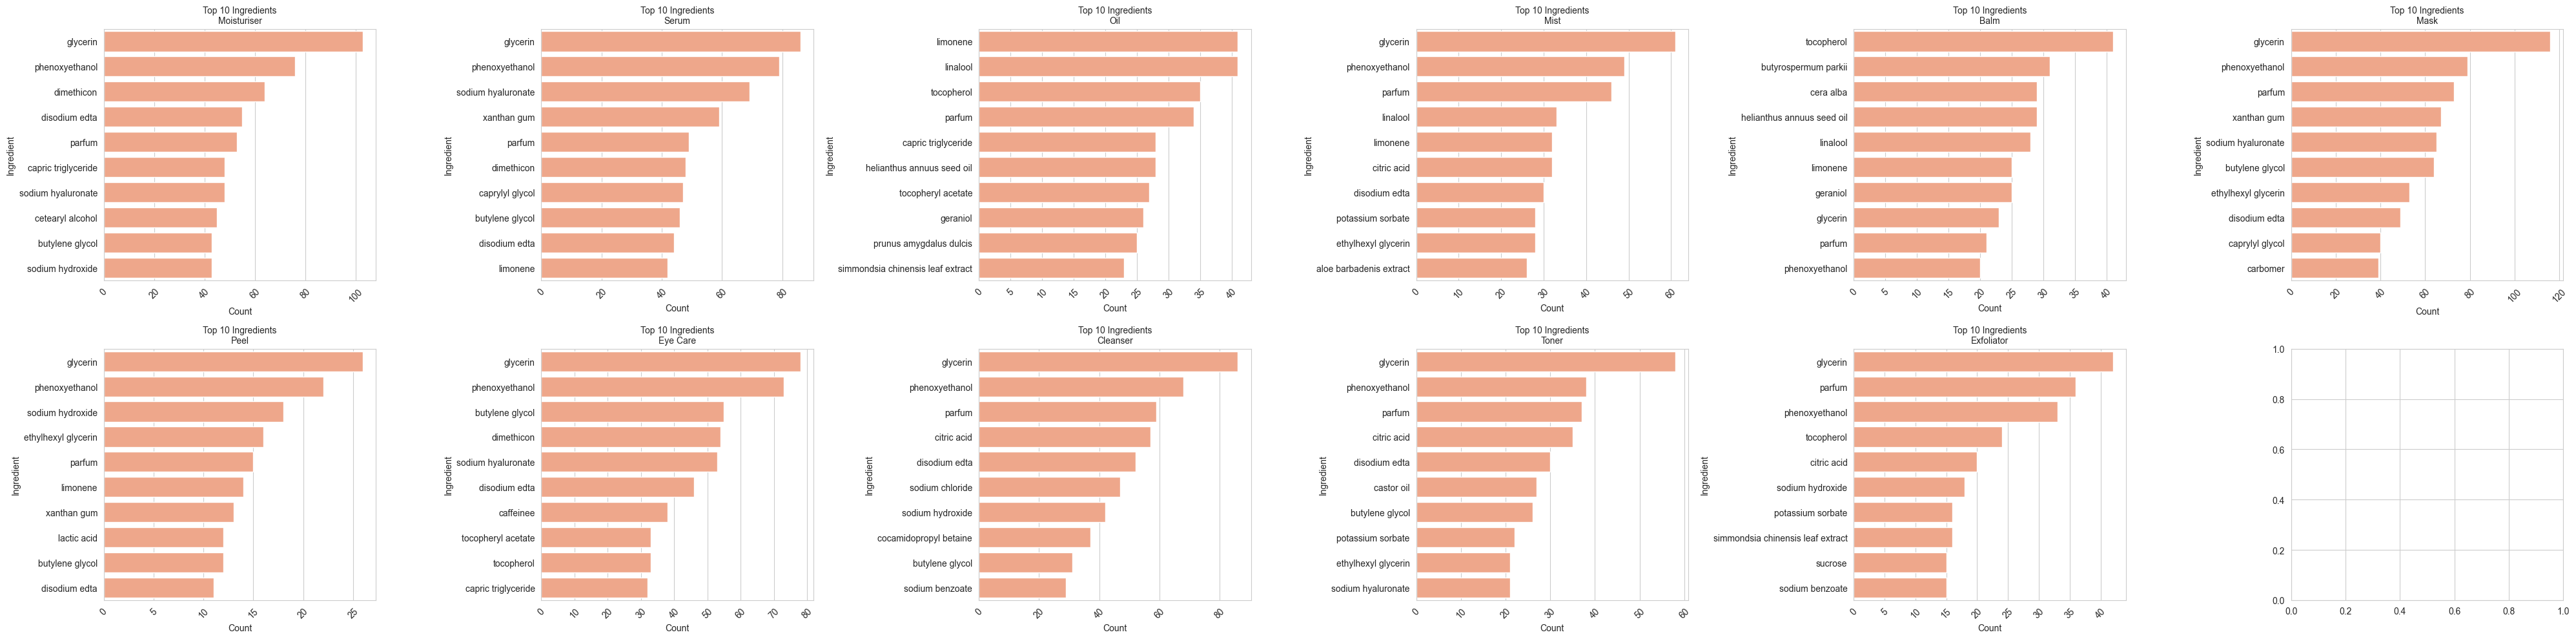

In [11]:
# ingredientes según tipo de producto
topk = 10
product_types = df.product_type.unique()

fig, axes = plt.subplots(2, 6, figsize=(40, 10)) # 2 x 6
axes = axes.flatten()
for i, product_type in enumerate(product_types):
    product_type_ingredients = df[df.product_type == product_type].clean_ingreds.explode().str.strip()
    ingredient_counts = Counter(product_type_ingredients)
    ingredient_counts_df = pd.DataFrame(ingredient_counts.items(), columns=['Ingredient', 'Count']).sort_values(by='Count', ascending=False)
    
    sns.barplot(x='Count', y='Ingredient', data=ingredient_counts_df.head(topk), ax=axes[i], color="lightsalmon")
    axes[i].set_title(f"Top {topk} Ingredients\n{product_type}", fontsize=10)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
# abrir la imagen aparte para ver

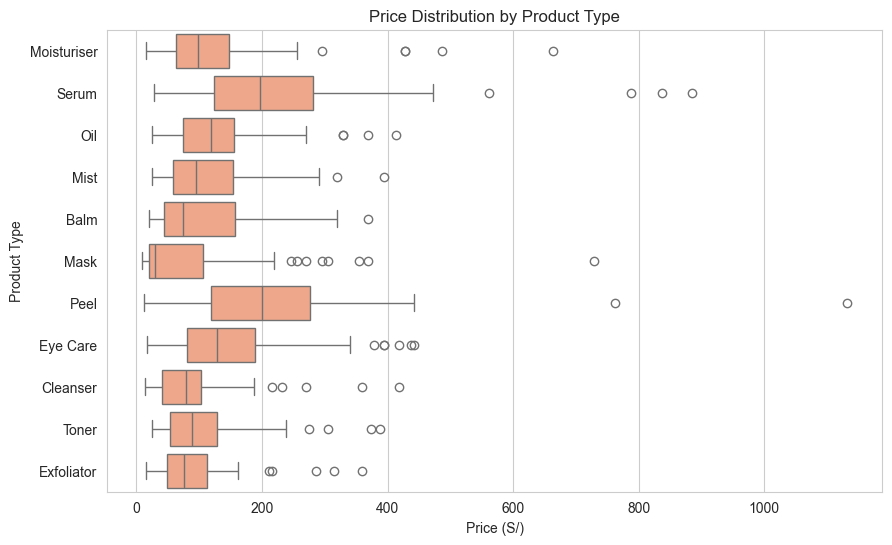

In [12]:
# distribución de precio por tipo de producto
df.price = df.price.str.strip("£")
df.price = df.price.astype(float)
df['price_soles'] = df.price * 4.92

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.boxplot(data = df, y='product_type', x='price_soles', color="lightsalmon")
plt.xlabel("Price (S/)")
plt.ylabel("Product Type")
plt.title("Price Distribution by Product Type")
plt.show()

In [13]:
# esto cuenta cuántas veces aparece cada ingrediente
all_ingredients = df.clean_ingreds.explode().str.strip()
ingredient_counts = Counter(all_ingredients)
ingredient_counts_df = pd.DataFrame(ingredient_counts.items(), columns=['Ingredient', 'Count']).sort_values(by='Count', ascending=False)
len(ingredient_counts_df)

2302

In [14]:

# df_exploded = df.explode('clean_ingreds')
# df_exploded['clean_ingreds'] = df_exploded['clean_ingreds'].str.strip()

# ingredient_counts = Counter(df_exploded['clean_ingreds'])
# top_10_ingredients = [ingredient for ingredient, _ in ingredient_counts.most_common(10)]

# df_top_ingredients = df_exploded[df_exploded['clean_ingreds'].isin(top_10_ingredients)]

# ingredient_product_counts = (
#     df_top_ingredients.groupby(['clean_ingreds', 'product_type'])
#     .size()
#     .reset_index(name='Count')
# )

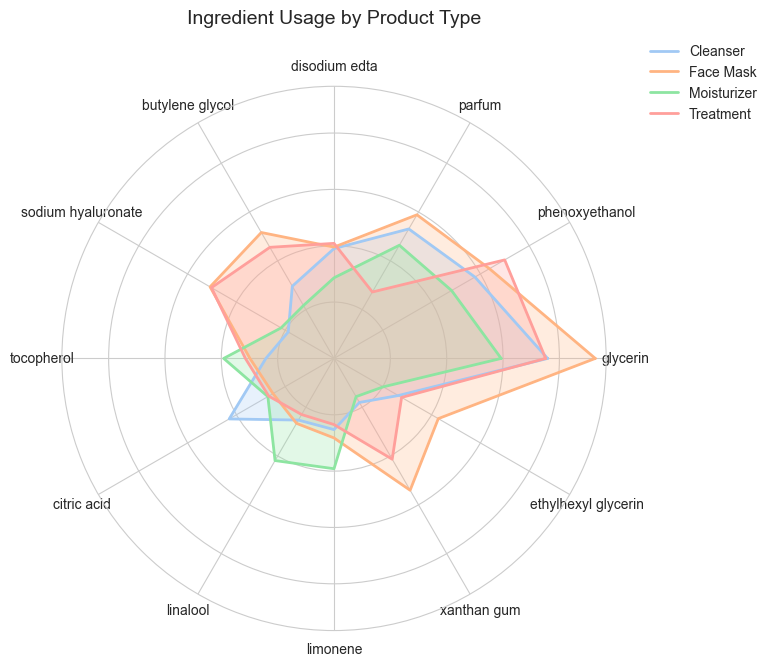

In [15]:
top_k = 12
top_ingredients = ingredient_counts_df.sort_values(by="Count", ascending=False).head(top_k)["Ingredient"].tolist()

for ingredient in top_ingredients:
    df[ingredient] = df["clean_ingreds"].apply(lambda x: 1 if ingredient in x else 0)

grouped = df.groupby("product_type_general")[top_ingredients].mean()

grouped = grouped.head(5)

labels = top_ingredients
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
labels += labels[:1]
angles += angles[:1]

colors = sns.color_palette("pastel", n_colors=len(grouped))

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for idx, (label, row) in enumerate(grouped.iterrows()):
    values = row.tolist()
    values += values[:1]
    ax.plot(angles, values, color=colors[idx], label=label, linewidth=2)
    ax.fill(angles, values, color=colors[idx], alpha=0.25)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels[:-1], fontsize=10)
ax.set_yticklabels([])
ax.set_title("Ingredient Usage by Product Type", size=14, y=1.1)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), frameon=False)

plt.tight_layout()
plt.show()

In [16]:
df['ingredients_str'] = df['clean_ingreds'].apply(lambda x: ' '.join(x))

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['ingredients_str'])

le = LabelEncoder()
y = le.fit_transform(df['product_type']) 

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# ¿Se puede predecir la categoría (moisturizer, cleanser, etc.) en base a los ingredientes? Usando un random forest
clf = RandomForestClassifier(max_depth=20, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.5
              precision    recall  f1-score   support

           0       0.57      0.50      0.53         8
           1       0.59      0.76      0.67        17
           2       0.80      0.31      0.44        13
           3       0.56      0.43      0.49        23
           4       0.67      0.64      0.65        28
           5       0.67      0.25      0.36        24
           6       0.46      0.74      0.57        23
           7       0.47      0.82      0.60        11
           8       1.00      0.12      0.22         8
           9       0.27      0.39      0.32        18
          10       0.32      0.35      0.33        17

    accuracy                           0.50       190
   macro avg       0.58      0.48      0.47       190
weighted avg       0.56      0.50      0.49       190

